## Introduction

Business Case - Taking Yelp information to create a Recommendation System with the Surprise model. I want to implement my model to become as successful as those within companies such as Netflix, Amazon, Hulu etc.

Recommendation Systems are very important with consumer retention. When a company invests into brand marketing, it's not a cheap endeavor. So, to make it all-for-not, the consumer retention aspect of the business needs to be strong in order to maintain accounts/viewers. The best way to ensure your business is meeting needs/demands of the consumer, a recommendation system should be put into place to offer similarly liked items/videos to what they are interested in.

## Importing Libraries/JSON Files

In [84]:
# import libraries
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import nltk
# nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize

from surprise import Dataset, Reader
from surprise import BaselineOnly, SVD, SVDpp, NMF
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from config import zach_key

# !pip install requests

In [2]:
df1 = pd.read_json('yelp_academic_dataset_business.json', lines=True).dropna(subset=['categories'])
df1.categories

0         Gastropubs, Food, Beer Gardens, Restaurants, B...
1         Salad, Soup, Sandwiches, Delis, Restaurants, C...
2         Antiques, Fashion, Used, Vintage & Consignment...
3                                Beauty & Spas, Hair Salons
4         Gyms, Active Life, Interval Training Gyms, Fit...
                                ...                        
160580    Real Estate, Real Estate Services, Home Servic...
160581        Health Markets, Food, Specialty Food, Grocery
160582    Arts & Entertainment, Paint & Sip, Art Classes...
160583                Cuban, Sandwiches, Restaurants, Cafes
160584    Restaurants, Middle Eastern, Mediterranean, Pe...
Name: categories, Length: 160470, dtype: object

In [3]:
# changing the commas to periods for creating dummy variables
df1['categories'] = df1['categories'].str.replace(',', '.')

In [4]:
vec = CountVectorizer(tokenizer=sent_tokenize, lowercase=False)

categories = vec.fit_transform(df1.dropna(subset=['categories'])['categories'])
categories = pd.DataFrame(categories.toarray(), columns=vec.get_feature_names())
duplicated = [c for c in categories.columns if '.' in c]
categories = categories[duplicated]
categories.columns = [c.strip('.') for c in categories.columns]

In [5]:
categories.columns.unique()

Index(['& Probates', '3D Printing', 'ATV Rentals/Tours', 'Acai Bowls',
       'Accessories', 'Accountants', 'Acne Treatment', 'Active Life',
       'Acupuncture', 'Addiction Medicine',
       ...
       'Wine Tours', 'Wineries', 'Women's Clothing',
       'Workers Compensation Law', 'Wraps', 'Yakiniku', 'Yelp Events', 'Yoga',
       'Ziplining', 'Zoos'],
      dtype='object', length=1350)

In [6]:
categories.sum().sort_values(ascending=False)[:30]

Restaurants                  37139
Food                         22290
Shopping                     20490
Home Services                12344
Beauty & Spas                12089
Health & Medical             11694
Nightlife                     9872
Local Services                9372
Bars                          8872
Event Planning & Services     7736
Active Life                   7199
Automotive                    7199
Sandwiches                    5758
Coffee & Tea                  5724
Fashion                       5346
American (Traditional)        5260
Home & Garden                 4570
Breakfast & Brunch            4440
American (New)                4382
Arts & Entertainment          4204
Hotels & Travel               4177
Hair Salons                   4176
Pizza                         4090
Real Estate                   3964
Fitness & Instruction         3864
Fast Food                     3840
Professional Services         3829
Doctors                       3645
Auto Repair         

In [7]:
# putting the categories df with the original
df2 = pd.concat([df1, categories], axis=1)

In [8]:
df2.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Wine Tours,Wineries,Women's Clothing,Workers Compensation Law,Wraps,Yakiniku,Yelp Events,Yoga,Ziplining,Zoos
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# top 20 categories
categories.sum().sort_values(ascending=False)[:20]

Restaurants                  37139
Food                         22290
Shopping                     20490
Home Services                12344
Beauty & Spas                12089
Health & Medical             11694
Nightlife                     9872
Local Services                9372
Bars                          8872
Event Planning & Services     7736
Active Life                   7199
Automotive                    7199
Sandwiches                    5758
Coffee & Tea                  5724
Fashion                       5346
American (Traditional)        5260
Home & Garden                 4570
Breakfast & Brunch            4440
American (New)                4382
Arts & Entertainment          4204
dtype: int64

In [10]:
# here's how you subset for restaurants and bars (the | acts like an OR)
# this takes a while

restaurants = df2.query('Restaurants == 1 | Bars == 1')
restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Wine Tours,Wineries,Women's Clothing,Workers Compensation Law,Wraps,Yakiniku,Yelp Events,Yoga,Ziplining,Zoos
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,ufCxltuh56FF4-ZFZ6cVhg,Sister Honey's,247 E Michigan St,Orlando,FL,32806,28.513265,-81.374707,4.5,135.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,GfWJ19Js7wX9rwaHQ7KbGw,Everything POP Shopping & Dining,1050 Century Dr,Orlando,FL,32830,28.350498,-81.542819,3.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
restaurants.shape

(40357, 1372)

## EDA

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160470 entries, 0 to 160584
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   160470 non-null  object 
 1   name          160470 non-null  object 
 2   address       160470 non-null  object 
 3   city          160470 non-null  object 
 4   state         160470 non-null  object 
 5   postal_code   160470 non-null  object 
 6   latitude      160470 non-null  float64
 7   longitude     160470 non-null  float64
 8   stars         160470 non-null  float64
 9   review_count  160470 non-null  int64  
 10  is_open       160470 non-null  int64  
 11  attributes    145591 non-null  object 
 12  categories    160470 non-null  object 
 13  hours         133241 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 23.4+ MB


Text(0.5, 1.0, 'Ratings Overview')

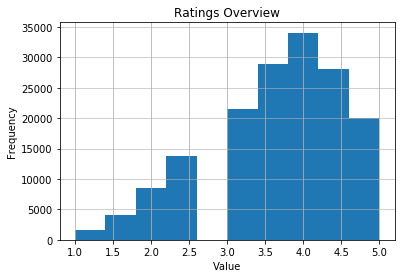

In [161]:
# This shows overall ratings with all businesses of dataset.
df1['stars'].hist()
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Ratings Overview')

Text(0.5, 1.0, 'Reviews Count Spread')

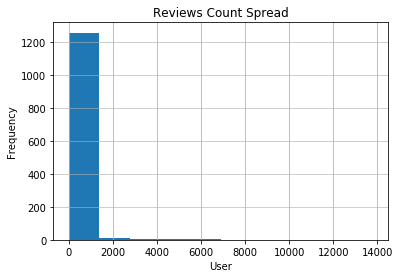

In [162]:
# A visual of how the majority of
df1['review_count'].value_counts().hist()
plt.grid(axis='y', alpha=0.75)
plt.xlabel('User')
plt.ylabel('Frequency')
plt.title('Reviews Count Spread')

Text(0.5, 1.0, 'Top Reviewed State Businesses')

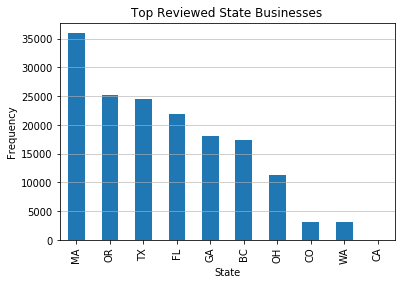

In [163]:
# Majority of ratings are only within 9 states
df1['state'].value_counts()[:10].plot(kind='bar')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('State')
plt.ylabel('Frequency')
plt.title('Top Reviewed State Businesses')

In [17]:
# Pickled new list of dictionaries from original JSON file
import pickle

In [18]:
# Opening the pickled reviews dictionary

with open('reviews.pkl', 'rb') as f:
    reviews = pickle.load(f)

In [19]:
# Converting dictionary into a pandas DataFrame for better readability
reviews = pd.DataFrame(reviews)
reviews

,user_id,business_id,stars
0,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0
1,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0
2,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0
3,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0
4,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0
...,...,...,...
8635398,6olZ0y9oW9azON61AhwxYg,yyTtwwQ4JnQMJ2rn3W0S0g,1.0
8635399,EPYNZQFuSKqLi-on3U9dFg,RDgwjgbu5xziFIAaNn3WCQ,1.0
8635400,tr13Jb83h2itjyXVwaO5eA,rbuj2X4SXIc3MDul4dcxIA,5.0
8635401,HqdmRMpNvScFxjGAB40vgQ,IRzjEZ2pX4iOpnBG7oZJ7g,2.0


In [69]:
# Assigning a variable to new data of the top ten users involved with the dataset because the top ten have 
#  more than one review.

rating_counts = reviews['user_id'].value_counts()[:10]
rating_counts

RtGqdDBvvBCjcu5dUqwfzA    6073
Xwnf20FKuikiHcSpcEbpKQ    3861
tgrs5VQ6thhouiEtMU-N_w    2265
j14WgRoU_-2ZE1aw1dXrJg    1958
jpIGlAym6z88W2xzHiK5_A    1671
9EeEpkZg5jV18N_KvrcT6g    1516
nl8gWLDo6U6MjqzbBmE_9A    1509
R1FVpAyl_BtxHBWdau2VLg    1497
Pf7FI0OukC_CEcCz0ZxoUw    1449
gqL5KBs2oS7qobnyd99iKg    1286
Name: user_id, dtype: int64

Text(0.5, 1.0, 'Users and their Reviews')

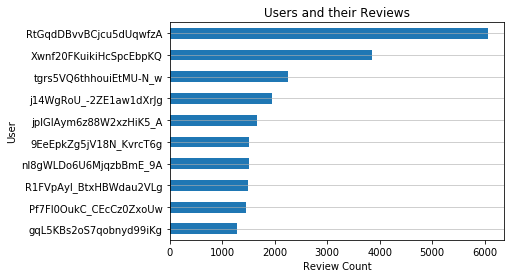

In [165]:
# Putting the numbers above into a easy to read horizontal bar graph.

rating_counts.sort_values().plot(kind='barh')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Review Count')
plt.ylabel('User')
plt.title('Users and their Reviews')

In [22]:
# Assigning a new variable to call upon that only show the user and their respective review count within data.

user_count = reviews['user_id'].value_counts().rename_axis('unique_values').reset_index(name='counts')

In [23]:
user_count

,unique_values,counts
0,RtGqdDBvvBCjcu5dUqwfzA,6073
1,Xwnf20FKuikiHcSpcEbpKQ,3861
2,tgrs5VQ6thhouiEtMU-N_w,2265
3,j14WgRoU_-2ZE1aw1dXrJg,1958
4,jpIGlAym6z88W2xzHiK5_A,1671
...,...,...
2189452,-YIC6RNgwad72SM48Taf8Q,1
2189453,0tzhQW4TFk0rAimfzBt3fQ,1
2189454,XgXP7GaBmJ5Bfsas-svbnA,1
2189455,GROXfaefwvXir12s2bPRPw,1


In [24]:
# I wanted to remove users that reviewed less than 100x for a few reasons; I wanted to shrink the data for faster
#  processing within my model and to include stronger data of users and their ratings.

user_count[user_count['counts']  > 100]

# You can see that the number of rows decreased over 2 million!! This is a test for further when I select my pool
#  of users to include with the final dataset to enter into the model for predicting.

,unique_values,counts
0,RtGqdDBvvBCjcu5dUqwfzA,6073
1,Xwnf20FKuikiHcSpcEbpKQ,3861
2,tgrs5VQ6thhouiEtMU-N_w,2265
3,j14WgRoU_-2ZE1aw1dXrJg,1958
4,jpIGlAym6z88W2xzHiK5_A,1671
...,...,...
5743,cTVJIVQBfEtsrPW0dM3z4A,101
5744,D_liFPO9WgITdQSun24geA,101
5745,JqEOJxG4J5ybEoBH363jwQ,101
5746,UU4zFYWXQKwqWLlt2veXMQ,101


Text(0.5, 1.0, 'User Review Spread')

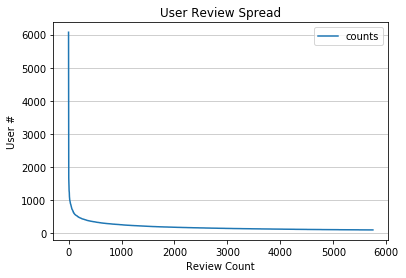

In [166]:
# Here you can see that the top user (6,073 reviews) really skews the data with reviews almost doubling the second 
#  most users vote count. By looking at the graph, on average, users within this dataset review approximately
#  300-500 times.

user_count[user_count['counts']  > 100].plot()
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Review Count')
plt.ylabel('User #')
plt.title('User Review Spread')

## Surprise Modeling

In [27]:
# Defining the rating scale for the model
reader = Reader(rating_scale=(1.0, 5.0))
# Assigning the data I want to load into the model with the 'data' variable.
data = Dataset.load_from_df(reviews[['user_id', 'business_id', 'stars']], reader)

In [28]:
# Train-Test Split
train, test = train_test_split(data, test_size=.2)

In [29]:
train

Now that the initial data has been loaded up within the variables, I can now proceed to build a function to run through all four of the models I've chosen.

### BaselineOnly, SVD, NMF, SVDpp

In [30]:
# Using the model selected to fit the trained data. 
def model_accuracy(model):
    model.fit(train)
# Assigning our model being used to test out the test set of data to 'predictions'
    predictions = model.test(test)
# Outputing the Root Means Squared Error accuracy of the prediction
    return accuracy.rmse(predictions)

In [31]:
Base = BaselineOnly()
model_accuracy(Base)

Estimating biases using als...
RMSE: 1.2711


1.2711125758551107

In [32]:
svd = SVD()
model_accuracy(svd)

RMSE: 1.2752


1.275181086489985

In [33]:
NMF = NMF()
model_accuracy(NMF)

RMSE: 1.4345


1.4345435432602005

In [34]:
SVDpp = SVDpp()
model_accuracy(SVDpp)

RMSE: 1.2839


1.2839164997578163

## Subset

Sub-setting the data will continue to clean up the 'noise' or low quality information. This should help with the accuracy of the model when using better quality information.

In [26]:
# This is showing the amount of users that voted 'x' amount of times. (e.g. 1,173,684 users only rated one buisness.

reviews['user_id'].value_counts().value_counts()

1       1173684
2        363249
3        179185
4        107674
5         70854
         ...   
517           1
518           1
519           1
520           1
6073          1
Name: user_id, Length: 621, dtype: int64

In [51]:
# Assigning new variable to a new list I'm creating of each user and their review counts > 100.

unique_users = user_count[user_count['counts']  > 100]['unique_values'].tolist()

In [81]:
# This code subsets the dataframe's 'reviews' column ['user_id']and checks to see what users 
#  have voted more than 100x on businesses. 

reviews_subset = reviews[reviews['user_id'].isin(unique_users)]
reviews_subset

,user_id,business_id,stars
1,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0
8,LWUnzwK0ILquLLZcHHE1Mw,mD-A9KOWADXvfrZfwDs-jw,4.0
21,ltn9yaWIarK_o4DeMT1duA,MJYb0fioM-X7jc_0RIYyqQ,4.0
23,d01SZKYmReEar7varZB0HQ,I2OblwJG8_XzFxxoHU0vVQ,4.0
29,SIP1Dfwy1M0HWzdgGg9H9g,I-qL4zwr62710OJBtVv28A,4.0
...,...,...,...
8635374,xnf9I953jVkJiqBIIjWJOg,qYANgZTvhdkarq8n1m68bg,4.0
8635381,9U30DANobkrn3Zlu6T9p6Q,biYgFkftCPue7g3upflUOg,4.0
8635383,_6up_KUwL5RsuWtK8fQxXg,vXTo69v2bGEyuBdT0X1hrw,5.0
8635392,mCanGeC78QwvqwSLpnZM_Q,K2XwYhodpeGWW6T57bZ88Q,5.0


In [118]:
# Isolating restaurants within all businesses of the dataset and making them into a list.
restaurant_id = restaurants['business_id'].tolist()

In [120]:
# Reviews_subset already has the users we want but has a lot of noise.
# Within this code, only restaurants are being pulled out.

reviews_final = reviews_subset[reviews_subset['business_id'].isin(restaurant_id)]

In [121]:
reviews_final.shape

(285129, 3)

In [167]:
reader = Reader(rating_scale=(1.0, 5.0))
data_subset = Dataset.load_from_df(reviews_final[['user_id', 'business_id', 'stars']], reader)

In [168]:
train, test = train_test_split(data_subset, test_size=.2)

In [169]:
train

In [170]:
from surprise import BaselineOnly, SVD, SVDpp, NMF

## Gridsearch CV

In [171]:
# These two types of parameters are the only relevant ones to utilize within this model.

svd_param_grid = {'n_factors': [5, 7, 10],
                  'reg_all': [0.002, 0.02, 0.1]}

In [172]:
# GridsearchCV will test out all possibilities of these parameter combinations.

svd_gs = GridSearchCV(algo_class = SVD, param_grid = svd_param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1, joblib_verbose=2)
svd_gs.fit(data_subset)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.8min finished


In [173]:
# Outputting the results of the GridsearchCV.
pd.DataFrame(svd_gs.cv_results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_reg_all
0,0.986510,0.989765,0.987866,0.988047,0.001335,7,0.772535,0.772730,0.771960,0.772408,0.000327,2,2.148101,0.071602,0.564566,0.020864,"{'n_factors': 5, 'reg_all': 0.002}",5,0.002
1,0.985842,0.989142,0.987533,0.987506,0.001347,4,0.772256,0.772444,0.771777,0.772159,0.000281,1,2.048519,0.011496,0.539508,0.013164,"{'n_factors': 5, 'reg_all': 0.02}",5,0.020
2,0.985218,0.988460,0.986618,0.986765,0.001328,2,0.772940,0.772778,0.772104,0.772608,0.000362,7,2.029776,0.007019,0.535276,0.008630,"{'n_factors': 5, 'reg_all': 0.1}",5,0.100
3,0.986484,0.989805,0.988133,0.988141,0.001356,8,0.772831,0.772733,0.771917,0.772494,0.000410,4,2.205931,0.032908,0.575463,0.046918,"{'n_factors': 7, 'reg_all': 0.002}",7,0.002
4,0.986304,0.989477,0.987580,0.987787,0.001304,5,0.772774,0.772689,0.771880,0.772448,0.000403,3,2.166869,0.000617,0.531541,0.014182,"{'n_factors': 7, 'reg_all': 0.02}",7,0.020
5,0.985239,0.988543,0.986712,0.986832,0.001352,3,0.772919,0.772867,0.772261,0.772682,0.000299,9,2.174468,0.010096,0.542475,0.012966,"{'n_factors': 7, 'reg_all': 0.1}",7,0.100
6,0.986705,0.989844,0.988099,0.988216,0.001284,9,0.772746,0.772815,0.772335,0.772632,0.000212,8,2.516341,0.012100,0.581226,0.045822,"{'n_factors': 10, 'reg_all': 0.002}",10,0.002
7,0.986347,0.989039,0.988057,0.987815,0.001112,6,0.772950,0.772360,0.772258,0.772523,0.000305,5,2.477000,0.016850,0.551242,0.029969,"{'n_factors': 10, 'reg_all': 0.02}",10,0.020
8,0.985088,0.988602,0.986446,0.986712,0.001447,1,0.772818,0.772962,0.772025,0.772602,0.000412,6,2.446622,0.025047,0.524415,0.007114,"{'n_factors': 10, 'reg_all': 0.1}",10,0.100


## Final Tuning to Model

Now that the parameters are tested and we know which ones work the best, we can re-run the model with them to see how much more accurate it is now. Out of curiosity, I wanted to re-run some of the other models to see how they reacted to the sub-setting.

In [174]:
def model_subset_accuracy(model):
    model.fit(train)
    predictions = model.test(test)
    return accuracy.rmse(predictions)

In [175]:
Base = BaselineOnly()
model_subset_accuracy(Base)

Estimating biases using als...
RMSE: 0.9815


0.9815071291294225

In [176]:
nmf = NMF()
model_subset_accuracy(nmf)

RMSE: 1.0733


1.0732509382309587

In [177]:
svd = SVD()
model_subset_accuracy(svd)

RMSE: 0.9828


0.9827900112778016

In [178]:
svd = SVD(n_factors = 10, reg_all = 0.020)
model_subset_accuracy(svd)

RMSE: 0.9802


0.9802378219042914

In [179]:
svd = SVD(n_factors = 5, reg_all = 0.020)
model_subset_accuracy(svd)

RMSE: 0.9804


0.9803944762054081

## Yelp API Access and Testing new data to the Final model

In [159]:
def top_five_unrated_biz(user):

# This creates a list of buisnesses the user HAS reviewed and making it into a list.
    previous_ratings = reviews_final[reviews_final['user_id'] == user]['business_id'].tolist()
# Assigning a variable 'new_restaurants' to create a list of businesses the user hasn't reviewed yet.
    new_restaurants = list(filter(lambda x: x not in previous_ratings, restaurant_id))

    new_list = []
    for x in new_restaurants:
#This next line adds the predicted value to the businesses the user hasn't reviewed yet.
        new_list.append((svd.predict(user, x)[3], x))
# Sorting list of tuples based upon the first element of each tuple; getting the top 5 results. 
    top_five = sorted(new_list, key=lambda tup: tup[0], reverse = True)[:5]
    for y in top_five:
        rating = round(y[0], 2)
        
        
        url = 'https://api.yelp.com/v3/businesses/'+ y[1]

        headers = {
        'Authorization': 'Bearer {}'.format(zach_key),
            }

        response = requests.get(url, headers=headers).json()
        print(response['name'], rating)


In [160]:
top_five_unrated_biz('ltn9yaWIarK_o4DeMT1duA')

Boston Roller Derby 4.74
Boda Borg 4.74
Mount Auburn Cemetery 4.72
Jeni's Splendid Ice Creams 4.68
Johnny's Pops 4.67
